In [1]:
import os
import tensorflow as tf
from tensorflow.contrib.slim import nets
from tensorflow.python import pywrap_tensorflow
slim = tf.contrib.slim

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
inputs = tf.placeholder(tf.float32, [None, 224, 224, 3], name="inputs")
with slim.arg_scope(nets.resnet_v1.resnet_arg_scope()):
    net, endpoints = nets.resnet_v1.resnet_v1_50(inputs, num_classes=1000, is_training=False)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [3]:
sess = tf.InteractiveSession()
pretrain_model = './resnet_v1_50.ckpt'

reader = pywrap_tensorflow.NewCheckpointReader(pretrain_model)
mean_RGB = reader.get_tensor("resnet_v1_50/mean_rgb")

variable_to_restore = slim.get_variables_to_restore()
init_fn = slim.assign_from_checkpoint_fn(pretrain_model, variable_to_restore, ignore_missing_vars=True)
init_fn(sess)

INFO:tensorflow:Restoring parameters from ./resnet_v1_50.ckpt


In [4]:
mean_RGB

array([123.15163 , 115.902885, 103.06262 ], dtype=float32)

In [5]:
endpoints

OrderedDict([('resnet_v1_50/conv1',
              <tf.Tensor 'resnet_v1_50/conv1/Relu:0' shape=(?, 112, 112, 64) dtype=float32>),
             ('resnet_v1_50/block1/unit_1/bottleneck_v1/shortcut',
              <tf.Tensor 'resnet_v1_50/block1/unit_1/bottleneck_v1/shortcut/BatchNorm/FusedBatchNorm:0' shape=(?, 56, 56, 256) dtype=float32>),
             ('resnet_v1_50/block1/unit_1/bottleneck_v1/conv1',
              <tf.Tensor 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv1/Relu:0' shape=(?, 56, 56, 64) dtype=float32>),
             ('resnet_v1_50/block1/unit_1/bottleneck_v1/conv2',
              <tf.Tensor 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv2/Relu:0' shape=(?, 56, 56, 64) dtype=float32>),
             ('resnet_v1_50/block1/unit_1/bottleneck_v1/conv3',
              <tf.Tensor 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv3/BatchNorm/FusedBatchNorm:0' shape=(?, 56, 56, 256) dtype=float32>),
             ('resnet_v1_50/block1/unit_1/bottleneck_v1',
              <tf.Tensor 're

# 某一层卷积层的热力图显示 

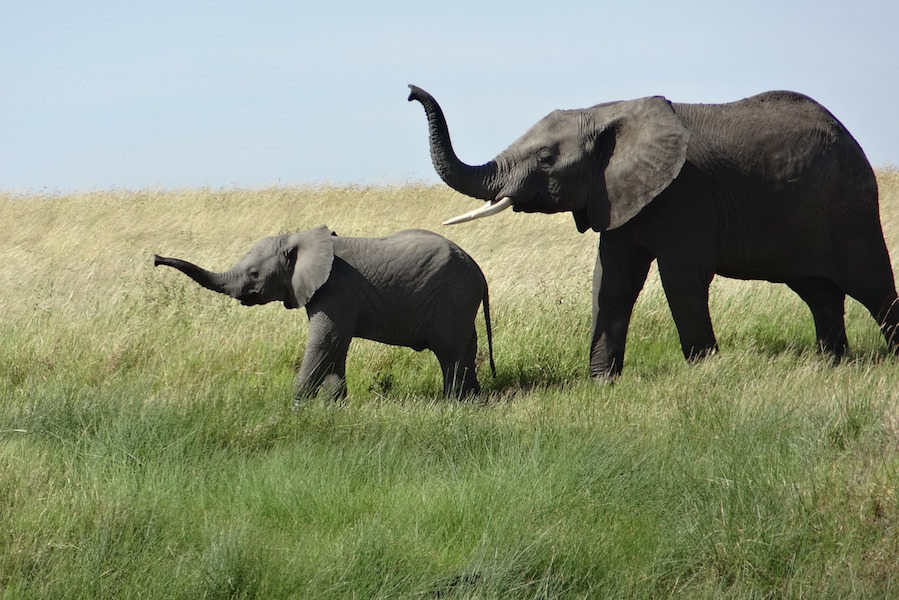

In [6]:
img = Image.open("./2.jpg").convert("RGB")
img

In [7]:
img = img.resize((224,224))
img = np.array(img).astype(np.float32)
img = img-mean_RGB
img = np.expand_dims(img,axis=0)

In [8]:
pred = np.squeeze(sess.run(endpoints["predictions"],feed_dict={inputs:img}))

In [9]:
cls = np.where(pred==np.max(pred))[0]
pred_val = np.max(pred)
print("%d classes: pred: %f"%(cls, pred_val))

386 classes: pred: 0.972806


In [10]:
african_elephant_output = tf.squeeze(endpoints["predictions"][:,:,:,386])
last_conv_layer = endpoints['resnet_v1_50/block4/unit_3/bottleneck_v1/conv3'] # 2048 layer
grads = tf.gradients(african_elephant_output, last_conv_layer)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
pooled_grads_output, last_conv_layer_output = sess.run([pooled_grads, last_conv_layer], feed_dict={inputs:img})

In [11]:
last_conv_layer_output = last_conv_layer_output[0]

In [12]:
for i in range(2048):
    last_conv_layer_output[:, :, i] *= pooled_grads_output[i]

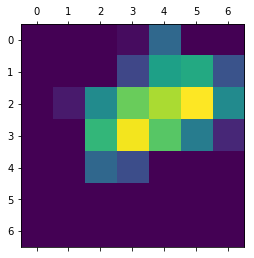

In [32]:
heatmap = np.mean(last_conv_layer_output, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [33]:
import cv2

# We use cv2 to load the original image
img = cv2.imread("./2.jpg")

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

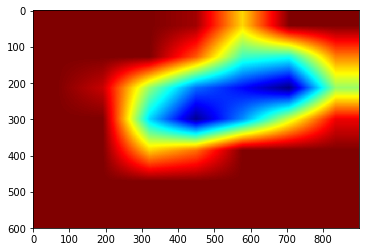

In [37]:
plt.imshow(heatmap)
plt.show()

In [34]:
# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./elephant_cam.jpg', superimposed_img)

True

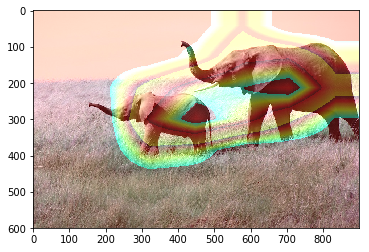

In [43]:
plt.imshow(np.uint8(superimposed_img))
plt.show()